In [1]:
import os
import glob
import sys

if("conda" in sys.modules):
    import conda.cli as cli
    cli.main('conda', 'install',  '-y', '-c schrodinger' , 'pymol')
else:
   print(os.environ[PYTHONPATH])




import numpy as np
import typing as t
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings as warn

from sklearn import decomposition as dec

from rdkit import Chem
from rdkit.Chem import AllChem

%matplotlib inline


BLAB


ModuleNotFoundError: No module named 'numpy'

In [6]:
#FUNCS
#Calc PCA
def _calc_pca(coords, dims):
    #center data: (scale)
    geometric_mean = np.mean(coords, axis=0)
    centered_coords = coords - geometric_mean
    #get covariance_matrix
    covariance_coords = np.cov((centered_coords[:,0],centered_coords[:,1]))
    #eigenvalue decomp. => principle components
    eigen_values, eigen_vectors = np.linalg.eig(covariance_coords)
    #transform coordinates onto new coords.
    transformed_coords = eigen_vectors[:,:dims].T.dot(centered_coords[:,:dims].T)
    return transformed_coords, eigen_vectors, eigen_values, covariance_coords


#Calculate polygon area!    #from plotly - 
def PolygonSort(corners,title=""):
    n = len(corners)
    cx = float(sum(x for x, y in corners)) / n
    cy = float(sum(y for x, y in corners)) / n
    cornersWithAngles = []
    for x, y in corners:
        an = (np.arctan2(y - cy, x - cx) + 2.0 * np.pi) % (2.0 * np.pi)
        cornersWithAngles.append((x, y, an))
    cornersWithAngles.sort(key = lambda tup: tup[2])
    last = []
    for x,y,an in cornersWithAngles:
        last.append((x,y))
    return last

def PolyArea(corners, title=""):  #Shoelace formula#from plotly - 
    corners = PolygonSort(corners[:,:2])
    print(corners)
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

#PLOT DATA
def _plot_data(coords, eigen_vectors, title):
    ##original data
    plt.scatter(coords[:,0],coords[:,1], c="k", label="data")
    plt.plot((-eigen_vectors[0,0], eigen_vectors[0,0]), (-eigen_vectors[0,1], eigen_vectors[0,1]), label="pc1")
    plt.plot((- eigen_vectors[1,0], eigen_vectors[1,0]), (-eigen_vectors[1,1], eigen_vectors[1,1]), label="pc2")
    plt.legend()
    plt.title("orig data - "+title)
    plt.show()
    
def _plot_pc_projection(projected_coords, title):
    ##porjection of data
    plt.scatter(projected_coords[0],projected_coords[1], c="k", label="data")
    plt.scatter(projected_coords[0], [0 for x in projected_coords[0]], c="r", label="prPC1")
    plt.scatter([0 for x in projected_coords[1]],projected_coords[1], c="b", label="prPC2")
    plt.legend()
    plt.title("pca_projection - "+title)
    plt.show()
    


def _plot_2D_PCA(coords, selected_arr, mol_name="", eig_vecs=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(coords[:, 0], coords[:, 1], c="k", alpha=0.4)
    ax.scatter(selected_arr[:, 0], selected_arr[:, 1], c="r", label="selected")

    if (not eig_vecs):
        for ind, vec in enumerate(eig_vecs):
            ax.plot((vec[0], vec[1]), label="pca" + str(ind))

    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_title("2DPCA " + mol_name + " molecule")
    ax.legend()

    fig.show()

def _plot_3D_PCA(coords, eig_vecs=None, mol_name=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ##vis mol
    ax.scatter(list(coords[:, 0]), list(coords[:, 1]),
               list(coords[:, 2]), c="k", alpha=0.4)
    ##vis selected
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c="r", label="selected")

    ##vis pca vector
    if (not eig_vecs):
        for ind, vec in enumerate(eig_vecs):
            ax.plot(xs=[0, 1 * vec[0]], ys=[0, 1 * vec[1]], zs=[0, 1 * vec[2]], label="pca" + str(ind))

    ##vis tuning
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    ax.set_title("3DPCA " + mol_name + " molecule")
    ax.legend()
    fig.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ##vis mol
    ax.scatter(list(coord_array_rescale_norm[:, 0]), list(coord_array_rescale_norm[:, 1]),
               list(coord_array_rescale_norm[:, 2]), c="k")

    ##vis pca vector
    if (not eig_vecs):
        for ind, vec in enumerate(eig_vecs):
            ax.plot(xs=[0, 1 * vec[0]], ys=[0, 1 * vec[1]], zs=[0, 1 * vec[2]], label="pca" + str(ind))

    ##vis tuning
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    ax.set_title("3DPCA " + title )
    ax.legend()
    fig.show()



In [7]:
Tests

NameError: name 'Tests' is not defined

In [8]:
def test_cases_simple(criterium_func, out_path=None):
    
    tests={
        1: ("rectangle", [[0, 0], [0,1], [1,0], [1,1]], None),
        2: ("biggerrectangle", [[0, 0], [0,2], [2,0], [2,2]], lambda x,y: x>=y),
        3: ("Triangle1", [[1, 1], [0,1], [1,0], [1,1]], lambda x,y: x<=y),
        4: ("Triangle2", [[0, 0], [1,0], [0,1], [0,0]], lambda x,y: x<=y),
        5: ("Triangle3", [[0, 0], [1,0], [1,0], [1,1]], lambda x,y: x<=y),
        6: ("Line1",  [[1, 1], [0,1], [0,1], [1,1]], lambda x,y: 0==y),
        7: ("Line2", [[1, 1], [1,0], [1,0], [1,1]], lambda x,y: 0==y),
        8: ("WORSE than RECT1", [[0, 0], [0,0.5], [1,0], [1,1]], lambda x,y: x<=y),
        9: ("WORSE than RECT2", [[0, 0], [0,1], [1,0], [0.5,1]], lambda x,y: x<=y),
        10: ("WORSE than RECT3", [[0, 0], [0,1], [0.5,0], [1,1]], lambda x,y: x<=y),
        11: ("WORSE than RECT5?",  [[0, 0], [0,1.0], [2,1], [2,2]], lambda x,y: x<=y),
        12: ("Better Rectangle1", [[0, 0], [0,1.5], [1,0], [1,1]], lambda x,y: x>=y),
        13: ("Better Rectangle2", [[0, 0], [0,1.0], [2,0], [2,2]], lambda x,y: x>=y),
        14: ("Better Rectangle3", [[0, -0.5], [0,1], [1,0], [1,1]], lambda x,y: x>=y),
        15: ("3DCuBE", [[0, 0, 0], [0,1,0], [1,1,0], [1,0,1]], lambda x,y: None),
        16: ("bigger3DCUBE", [[0, 0, 0], [0,1,0], [2,2,0], [1,0,2]], lambda x,y: x>=y),
        17: ("3DvarinZ", [[0, 0, 1], [0,1,8], [1,1,6], [1,0,5]], lambda x,y: x>=y),

    }
    
    def do_test(tests:dict):
        msg = "title\tarea\tcoords\n" 
        area_1 = 0
        for key, (title, coords, not_result) in sorted(tests.items(), key=lambda x: x[0]):
            tmp_area =criterium_func(np.array(coords),title)
            msg+=title+"\t"+str(tmp_area)+"\t"+"  ".join(map(lambda x: " ".join(map(str, x)), coords))+"\n"
            if not (not_result):
                area_1 = tmp_area
            else:
                if(not_result(area_1, tmp_area)):
                    warn.warn("Result is unexpected!\n For this: "+str(np.round(tmp_area,3))+ " vs. rectangle: "+str(area_1)+"\n")
        return msg
    
    msg = do_test(tests)
    msg = "\nMethod: "+criterium_func.__name__+"\n"+msg+"\n"

    print(msg)
    if(out_path):
        file = open(out_path, "a")
        file.write(msg)
        file.close()
        

In [4]:
def test_case_molecule(criterium_func):
    
    
    mol_path="/home/bschroed/code/restraintmaker/test/test_files/ligand_system/single_ligs_good"
    mols = [Chem.MolFromPDBFile(path) for path in glob.glob(mol_path+"/*pdb") ]
    [setattr(mol, "name", os.path.basename(path).replace(".pdb", "")) for path, mol in zip(glob.glob(mol_path+"/*pdb"), mols)]
    
    #get coords
    mol=mols[0]
    conf = mol.GetConformers()[0]
    pos = conf.GetPositions()

    #get selected-coords
    selected_atom_idxs = [8, 14, 18, 25]    
    selected_arr = np.array([list(pos[sele]) for sele in selected_atom_idxs])   
    print(selected_arr)

    title = "first_mol"
    tmp_area2 = criterium_func(selected_arr,title)
    print(title, "\t ", tmp_area2)
    pass

In [5]:
def test_case_molecule_rdkit(criterium_func):
    
    
    mol_path="/home/bschroed/code/restraintmaker/test/test_files/ligand_system/single_ligs_good"
    mols = [Chem.MolFromPDBFile(path) for path in glob.glob(mol_path+"/*pdb") ]
    [setattr(mol, "name", os.path.basename(path).replace(".pdb", "")) for path, mol in zip(glob.glob(mol_path+"/*pdb"), mols)]
    
    #get coords
    mol=mols[0]
    selected_atom_idxs = [8, 14, 18, 25]   
    title = "first_mol"
    tmp_area2 = criterium_func(mol,selected_atom_idxs,title)
    print(title, "\t ", tmp_area2)
    pass

In [17]:
"""
This function is simply doing the PCA and than calculating the area from maximal projected points. each point can be chosen once
"""   
def pca_2Darea(coords:np.array, title:str):
    #CALC_PCA
    dims = 2
    
    #Calculate _pca
    transformed_coords, pc_components, eigen_values, covaricance_matrix = _calc_pca(coords, dims)
    
    spacer = "\n##########################################################################\n"
    print(spacer+"\t\t"+title+spacer)
    print("PCA: ")
    print("\tcovariance: \n\t","\n\t ".join(map(str, list(covaricance_matrix))))
    print("\tPC: \n\t", "\n\t ".join(map(str, list(pc_components))))
    print("\teigenvalues: ",eigen_values)
    
    #CALCULATE AREA - CRITERIUM
    #never pick points twice!
    #calc area of rectange:
    max_pc1 = max(transformed_coords[0])
    min_pc1 = min(transformed_coords[0])
    height = abs(max_pc1-min_pc1)

    max_indices= [ind for ind, x in enumerate(transformed_coords[0]) if(x == max_pc1)]
    min_indices= [ind for ind, x in enumerate(transformed_coords[0]) if(x == min_pc1)]

    #try all index combinations if multiple max and min values are present
    area = 0            
    for x1 in max_indices:
        for x2 in min_indices:
            picked = (x1, x2)
            reduced= [x for ind,x in enumerate(transformed_coords[1]) if not (ind in picked)]
            
            max_pc2 = max(reduced)
            min_pc2 = min(reduced)
            width = abs(max_pc2-min_pc2)

            #make use of covariance in eval criterium
            tmp_area = width*height
                               
            #print("TMParea: ", tmp_area)
            if(tmp_area > area):
                area = tmp_area
    
    print("\nEVALUATION: ")
    print("\ttransfcoords:\n\t", "\n\t ".join(map(str, list(transformed_coords.T))))
    print("\tfingarea: ", area)
    print()
    
    #PLOT
    #plot orig data
    _plot_data(coords, pc_components, title)
    ##porjection of data
    _plot_pc_projection(transformed_coords, title)
    print()
    print()
    return area
    


##########################################################################
		rectangle
##########################################################################

PCA: 
	covariance: 
	 [0.33333333 0.        ]
	 [0.         0.33333333]
	PC: 
	 [1. 0.]
	 [0. 1.]
	eigenvalues:  [0.33333333 0.33333333]

EVALUATION: 
	transfcoords:
	 [-0.5 -0.5]
	 [-0.5  0.5]
	 [ 0.5 -0.5]
	 [0.5 0.5]
	fingarea:  1.0



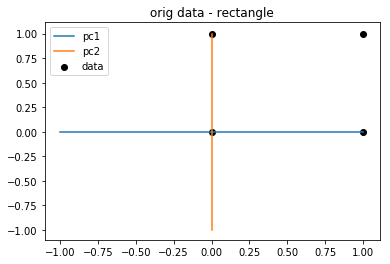

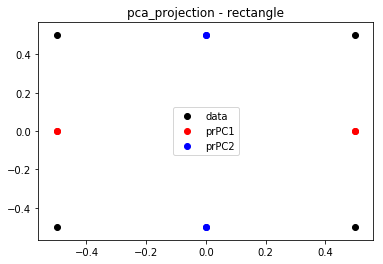




##########################################################################
		biggerrectangle
##########################################################################

PCA: 
	covariance: 
	 [1.33333333 0.        ]
	 [0.         1.33333333]
	PC: 
	 [1. 0.]
	 [0. 1.]
	eigenvalues:  [1.33333333 1.33333333]

EVALUATION: 
	transfcoords:
	 [-1. -1.]
	 [-1.  1.]
	 [ 1. -1.]
	 [1. 1.]
	fingarea:  4.0



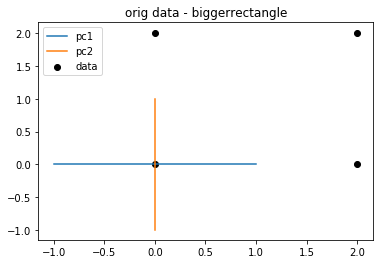

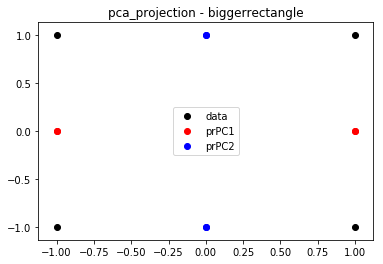




##########################################################################
		Triangle1
##########################################################################

PCA: 
	covariance: 
	 [ 0.25       -0.08333333]
	 [-0.08333333  0.25      ]
	PC: 
	 [0.70710678 0.70710678]
	 [-0.70710678  0.70710678]
	eigenvalues:  [0.33333333 0.16666667]

EVALUATION: 
	transfcoords:
	 [0.         0.35355339]
	 [-0.70710678 -0.35355339]
	 [ 0.70710678 -0.35355339]
	 [0.         0.35355339]
	fingarea:  0



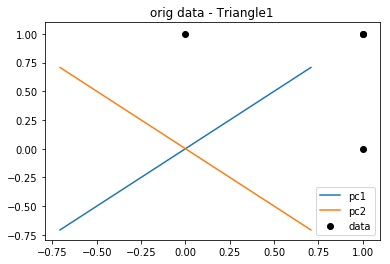

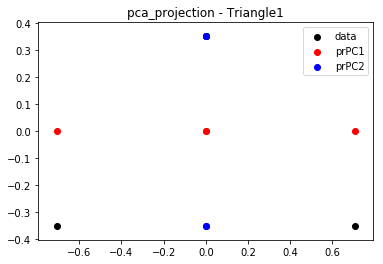




##########################################################################
		Triangle2
##########################################################################

PCA: 
	covariance: 
	 [ 0.25       -0.08333333]
	 [-0.08333333  0.25      ]
	PC: 
	 [0.70710678 0.70710678]
	 [-0.70710678  0.70710678]
	eigenvalues:  [0.33333333 0.16666667]

EVALUATION: 
	transfcoords:
	 [ 0.         -0.35355339]
	 [0.70710678 0.35355339]
	 [-0.70710678  0.35355339]
	 [ 0.         -0.35355339]
	fingarea:  0


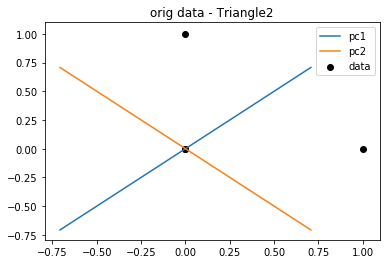

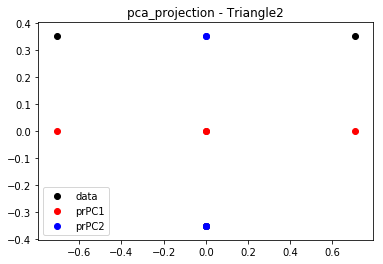




##########################################################################
		Triangle3
##########################################################################

PCA: 
	covariance: 
	 [0.25       0.08333333]
	 [0.08333333 0.25      ]
	PC: 
	 [ 0.70710678 -0.70710678]
	 [0.70710678 0.70710678]
	eigenvalues:  [0.33333333 0.16666667]

EVALUATION: 
	transfcoords:
	 [-0.70710678  0.35355339]
	 [ 0.         -0.35355339]
	 [ 0.         -0.35355339]
	 [0.70710678 0.35355339]
	fingarea:  0



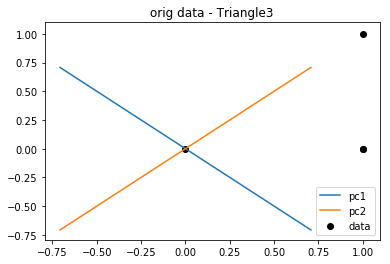

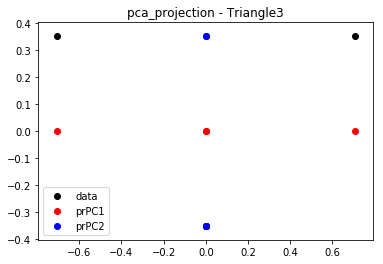




##########################################################################
		Line1
##########################################################################

PCA: 
	covariance: 
	 [0.33333333 0.        ]
	 [0. 0.]
	PC: 
	 [1. 0.]
	 [0. 1.]
	eigenvalues:  [0.33333333 0.        ]

EVALUATION: 
	transfcoords:
	 [0.5 0. ]
	 [-0.5  0. ]
	 [-0.5  0. ]
	 [0.5 0. ]
	fingarea:  0



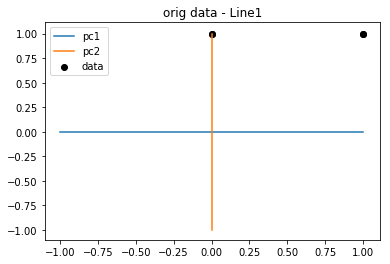

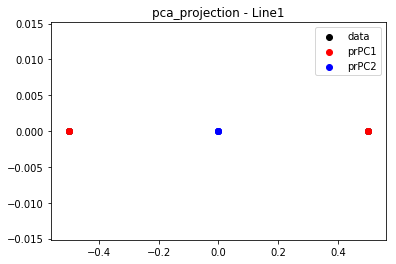




##########################################################################
		Line2
##########################################################################

PCA: 
	covariance: 
	 [0. 0.]
	 [0.         0.33333333]
	PC: 
	 [1. 0.]
	 [0. 1.]
	eigenvalues:  [0.         0.33333333]

EVALUATION: 
	transfcoords:
	 [0.  0.5]
	 [ 0.  -0.5]
	 [ 0.  -0.5]
	 [0.  0.5]
	fingarea:  0



/home/bschroed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Result is unexpected!
 For this: 0 vs. rectangle: 1.0



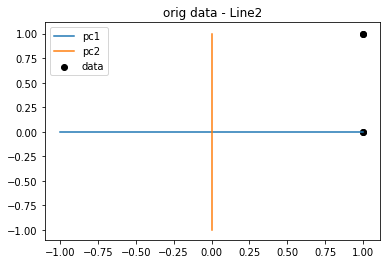

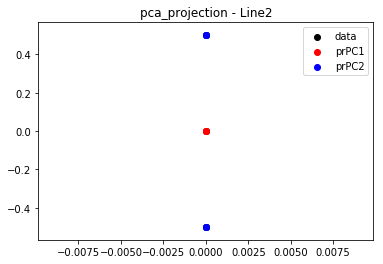




##########################################################################
		WORSE than RECT1
##########################################################################

PCA: 
	covariance: 
	 [0.33333333 0.08333333]
	 [0.08333333 0.22916667]
	PC: 
	 [ 0.87464248 -0.48476853]
	 [0.48476853 0.87464248]
	eigenvalues:  [0.37952064 0.18297936]

EVALUATION: 
	transfcoords:
	 [-0.61910944 -0.08560666]
	 [-0.37672517  0.35171458]
	 [ 0.25553304 -0.5703752 ]
	 [0.74030157 0.30426728]
	fingarea:  1.2534989930030211



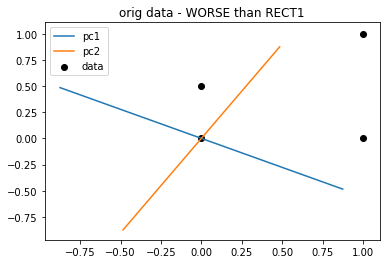

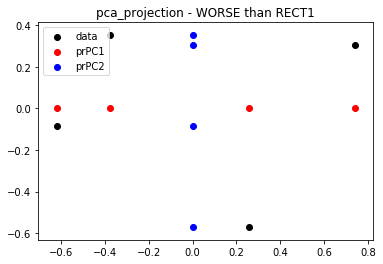




##########################################################################
		WORSE than RECT2
##########################################################################

PCA: 
	covariance: 
	 [ 0.22916667 -0.08333333]
	 [-0.08333333  0.33333333]
	PC: 
	 [-0.87464248  0.48476853]
	 [-0.48476853 -0.87464248]
	eigenvalues:  [0.18297936 0.37952064]

EVALUATION: 
	transfcoords:
	 [0.5703752  0.25553304]
	 [ 0.08560666 -0.61910944]
	 [-0.30426728  0.74030157]
	 [-0.35171458 -0.37672517]
	fingarea:  1.2534989930030211



/home/bschroed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Result is unexpected!
 For this: 1.253 vs. rectangle: 1.0



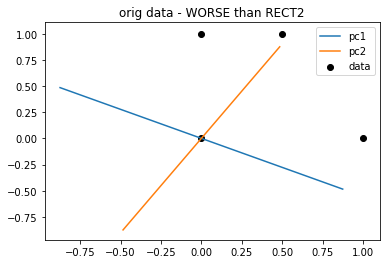

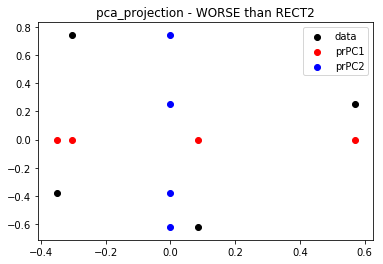




##########################################################################
		WORSE than RECT3
##########################################################################

PCA: 
	covariance: 
	 [0.22916667 0.08333333]
	 [0.08333333 0.33333333]
	PC: 
	 [-0.87464248 -0.48476853]
	 [ 0.48476853 -0.87464248]
	eigenvalues:  [0.18297936 0.37952064]

EVALUATION: 
	transfcoords:
	 [0.08560666 0.61910944]
	 [ 0.5703752  -0.25553304]
	 [-0.35171458  0.37672517]
	 [-0.30426728 -0.74030157]
	fingarea:  1.2534989930030211



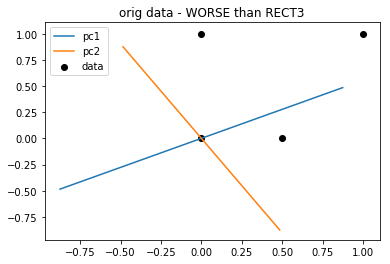

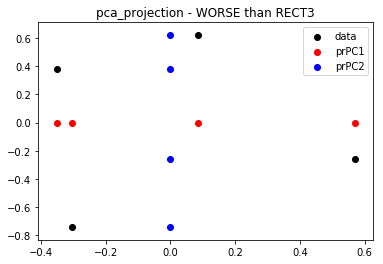




##########################################################################
		WORSE than RECT5?
##########################################################################

PCA: 
	covariance: 
	 [1.33333333 0.66666667]
	 [0.66666667 0.66666667]
	PC: 
	 [ 0.85065081 -0.52573111]
	 [0.52573111 0.85065081]
	eigenvalues:  [1.74535599 0.25464401]

EVALUATION: 
	transfcoords:
	 [-1.37638192 -0.3249197 ]
	 [-0.85065081  0.52573111]
	 [ 0.85065081 -0.52573111]
	 [1.37638192 0.3249197 ]
	fingarea:  2.894427190999915



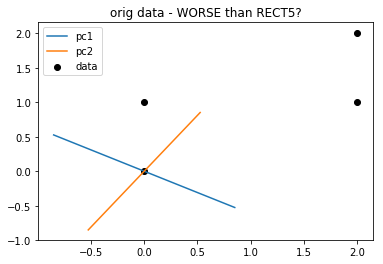

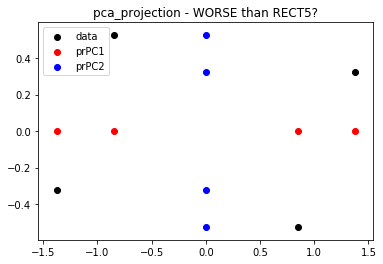




##########################################################################
		Better Rectangle1
##########################################################################

PCA: 
	covariance: 
	 [ 0.33333333 -0.08333333]
	 [-0.08333333  0.5625    ]
	PC: 
	 [-0.95098267  0.30924417]
	 [-0.30924417 -0.95098267]
	eigenvalues:  [0.30623468 0.58959865]

EVALUATION: 
	transfcoords:
	 [0.66876894 0.43974208]
	 [ 0.20490269 -0.98673192]
	 [-0.28221373  0.74898626]
	 [-0.5914579  -0.20199642]
	fingarea:  2.187398643169605



/home/bschroed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Result is unexpected!
 For this: 2.894 vs. rectangle: 1.0



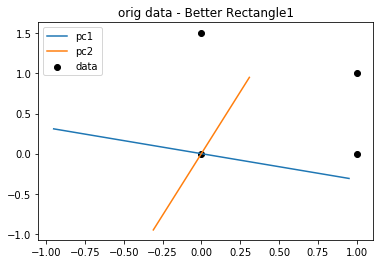

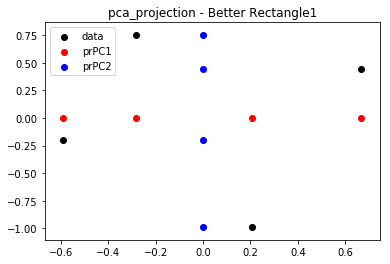




##########################################################################
		Better Rectangle2
##########################################################################

PCA: 
	covariance: 
	 [1.33333333 0.33333333]
	 [0.33333333 0.91666667]
	PC: 
	 [ 0.87464248 -0.48476853]
	 [0.48476853 0.87464248]
	eigenvalues:  [1.51808255 0.73191745]

EVALUATION: 
	transfcoords:
	 [-1.23821888 -0.17121333]
	 [-0.75345035  0.70342915]
	 [ 0.51106608 -1.14075039]
	 [1.48060315 0.60853457]
	fingarea:  5.013995972012085



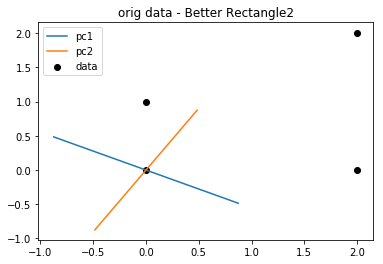

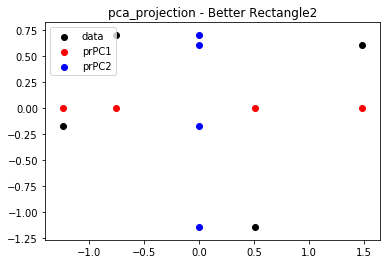




##########################################################################
		Better Rectangle3
##########################################################################

PCA: 
	covariance: 
	 [0.33333333 0.08333333]
	 [0.08333333 0.5625    ]
	PC: 
	 [-0.95098267 -0.30924417]
	 [ 0.30924417 -0.95098267]
	eigenvalues:  [0.30623468 0.58959865]

EVALUATION: 
	transfcoords:
	 [0.20490269 0.98673192]
	 [ 0.66876894 -0.43974208]
	 [-0.5914579   0.20199642]
	 [-0.28221373 -0.74898626]
	fingarea:  2.187398643169605



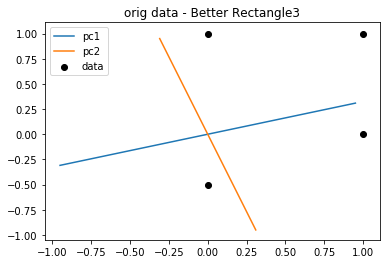

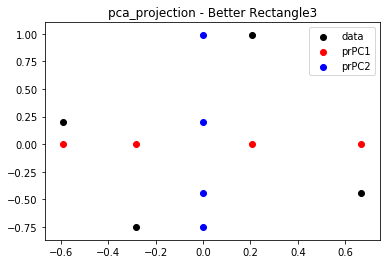




Method: pca_2Darea
title	area	coords
rectangle	1.0	0 0  0 1  1 0  1 1
biggerrectangle	4.0	0 0  0 2  2 0  2 2
Triangle1	0	1 1  0 1  1 0  1 1
Triangle2	0	0 0  1 0  0 1  0 0
Triangle3	0	0 0  1 0  1 0  1 1
Line1	0	1 1  0 1  0 1  1 1
Line2	0	1 1  1 0  1 0  1 1
WORSE than RECT1	1.2534989930030211	0 0  0 0.5  1 0  1 1
WORSE than RECT2	1.2534989930030211	0 0  0 1  1 0  0.5 1
WORSE than RECT3	1.2534989930030211	0 0  0 1  0.5 0  1 1
WORSE than RECT5?	2.894427190999915	0 0  0 1.0  2 1  2 2
Better Rectangle1	2.187398643169605	0 0  0 1.5  1 0  1 1
Better Rectangle2	5.013995972012085	0 0  0 1.0  2 0  2 2
Better Rectangle3	2.187398643169605	0 -0.5  0 1  1 0  1 1



In [30]:
test_cases_simple(pca_2Darea)

In [183]:
#tried alternative package for pca

def pca_2Darea_sklearn(coords:np.array, title:str):

    pca = dec.PCA(2)
    pcar = pca.fit(coords)    
    #get covariance_matrix
    covariance_coords = pca.get_covariance()
    #eigenvalue decomp. => principle components
    eigen_vectors = pca.components_
    #transform coordinates onto new coords.
    transformed_coords = pca.transform(coords).T
    
    spacer = "\n##########################################################################\n"
    print(spacer+"\t\t"+title+spacer)
    
    print("PCA: ")
    print("\tcovariance: \n\t","\n\t ".join(map(str, list(covariance_coords))))
    print("\tPC: \n\t", "\n\t ".join(map(str, list(eigen_vectors))))
    #print("\teigenvalues: ",eigen_values)
    
    #never pick points twice!
    #calc area of rectange:
    max_pc1 = max(transformed_coords[0])
    min_pc1 = min(transformed_coords[0])
    height = abs(max_pc1-min_pc1)

    max_indices= [ind for ind, x in enumerate(transformed_coords[0]) if(x == max_pc1)]
    min_indices= [ind for ind, x in enumerate(transformed_coords[0]) if(x == min_pc1)]

    #try all index combinations if multiple max and min values are present
    area = 0            
    for x1 in max_indices:
        for x2 in min_indices:
            picked = (x1, x2)
            reduced= [x for ind,x in enumerate(transformed_coords[1]) if not (ind in picked)]
            
            max_pc2 = max(reduced)
            min_pc2 = min(reduced)
            width = abs(max_pc2-min_pc2)
            
            #reduced list
            #print("picked", picked)
            #print("red",reduced)
            #print("TMPwidth: ", width, "=", abs(max_pc2), "-", min_pc2)
            #print("TMPheight: ", height, "=", abs(max_pc1), "-", min_pc1)
        
            #make use of covariance in eval criterium
            tmp_area = width*height
                
                
            #print("TMParea: ", tmp_area)
            if(tmp_area > area):
                area = tmp_area
    
    print("\nEVALUATION: ")
    print("\ttransfcoords:\n\t", "\n\t ".join(map(str, list(transformed_coords.T))))
    print("\twidth: ", width, "=", abs(max_pc2), "-", min_pc2)
    print("\theight: ", height, "=", abs(max_pc1), "-", min_pc1)
    print("\tfingarea: ", area)
    print()
    
    
    #PLOT
    #plot orig data
    _plot_data(coords,eigen_vectors, title)
    ##porjection of data
    _plot_pc_projection(transformed_coords, title)
    print()
    print()


    return area
    

'pca_2Darea'


##########################################################################
		rectangle
##########################################################################

PCA: 
	covariance: 
	 [0.33333333 0.        ]
	 [0.         0.33333333]
	PC: 
	 [-1. -0.]
	 [-0. -1.]

EVALUATION: 
	transfcoords:
	 [0.5 0.5]
	 [ 0.5 -0.5]
	 [-0.5  0.5]
	 [-0.5 -0.5]
	width:  0.0 = 0.5 - 0.5
	height:  1.0 = 0.5 - -0.5
	fingarea:  1.0



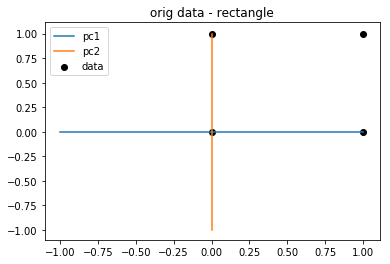

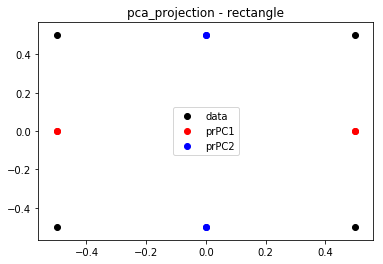



rectangle 	 1.0

##########################################################################
		biggerrectangle
##########################################################################

PCA: 
	covariance: 
	 [1.33333333 0.        ]
	 [0.         1.33333333]
	PC: 
	 [-1. -0.]
	 [-0. -1.]

EVALUATION: 
	transfcoords:
	 [1. 1.]
	 [ 1. -1.]
	 [-1.  1.]
	 [-1. -1.]
	width:  0.0 = 1.0 - 1.0
	height:  2.0 = 1.0 - -1.0
	fingarea:  4.0



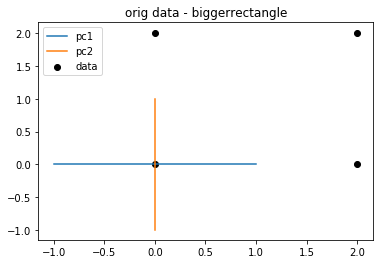

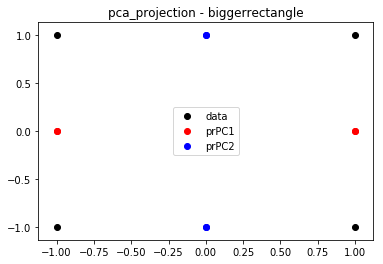



biggerrectangle 	  4.0

##########################################################################
		Triangle
##########################################################################

PCA: 
	covariance: 
	 [ 0.25       -0.08333333]
	 [-0.08333333  0.25      ]
	PC: 
	 [-0.70710678  0.70710678]
	 [0.70710678 0.70710678]

EVALUATION: 
	transfcoords:
	 [-2.77555756e-17  3.53553391e-01]
	 [ 0.70710678 -0.35355339]
	 [-0.70710678 -0.35355339]
	 [-2.77555756e-17  3.53553391e-01]
	width:  0.0 = 0.35355339059327373 - 0.35355339059327373
	height:  1.414213562373095 = 0.7071067811865476 - -0.7071067811865475
	fingarea:  0



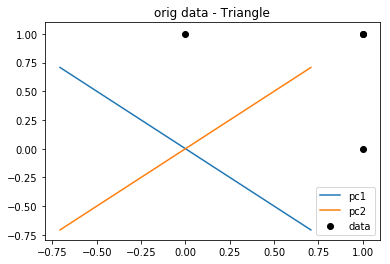

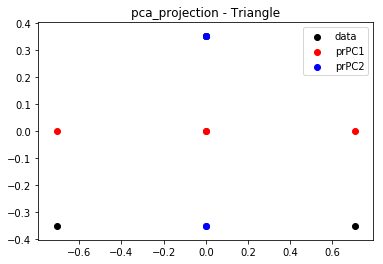



Triangle 	  0

##########################################################################
		Line
##########################################################################

PCA: 
	covariance: 
	 [0.33333333 0.        ]
	 [0. 0.]
	PC: 
	 [1. 0.]
	 [0. 1.]

EVALUATION: 
	transfcoords:
	 [0.5 0. ]
	 [-0.5  0. ]
	 [-0.5  0. ]
	 [0.5 0. ]
	width:  0.0 = 0.0 - 0.0
	height:  1.0 = 0.5 - -0.5
	fingarea:  0



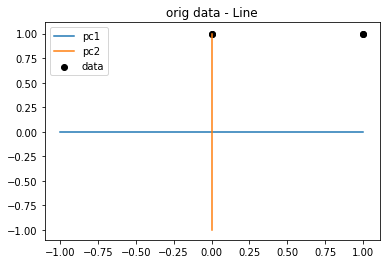

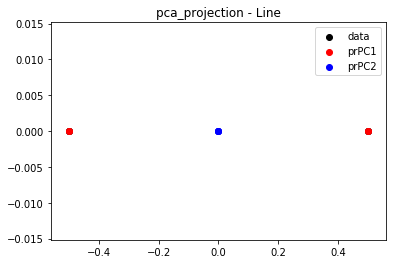



Line 	  0

##########################################################################
		WORSE than RECT1
##########################################################################

PCA: 
	covariance: 
	 [0.33333333 0.08333333]
	 [0.08333333 0.22916667]
	PC: 
	 [0.87464248 0.48476853]
	 [ 0.48476853 -0.87464248]

EVALUATION: 
	transfcoords:
	 [-0.61910944  0.08560666]
	 [-0.37672517 -0.35171458]
	 [0.25553304 0.5703752 ]
	 [ 0.74030157 -0.30426728]
	width:  0.9220897730163542 = 0.5703751966640294 - -0.35171457635232484
	height:  1.359411013639763 = 0.7403015733689997 - -0.6191094402707633
	fingarea:  1.2534989930030211



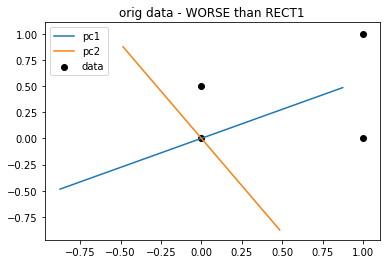

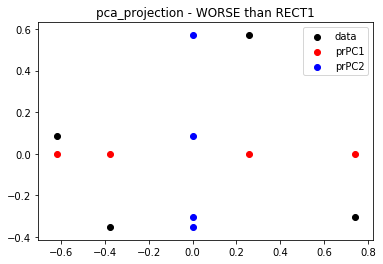



WORSE than RECT1 	  1.2534989930030211

##########################################################################
		WORSE than RECT2
##########################################################################

PCA: 
	covariance: 
	 [1.33333333 0.66666667]
	 [0.66666667 0.66666667]
	PC: 
	 [-0.85065081 -0.52573111]
	 [ 0.52573111 -0.85065081]

EVALUATION: 
	transfcoords:
	 [1.37638192 0.3249197 ]
	 [ 0.85065081 -0.52573111]
	 [-0.85065081  0.52573111]
	 [-1.37638192 -0.3249197 ]
	width:  1.0514622242382672 = 0.5257311121191336 - -0.5257311121191336
	height:  2.7527638409423467 = 1.3763819204711734 - -1.3763819204711734
	fingarea:  2.8944271909999153



/home/bschroed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: 	WORSE than RECT1
This Area should be smaller!
 BUt it is: 1.2534989930030211 vs. 1.0



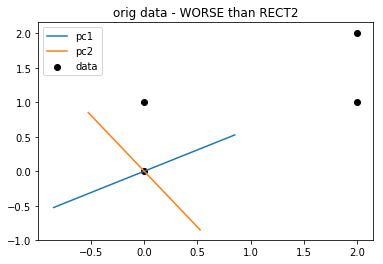

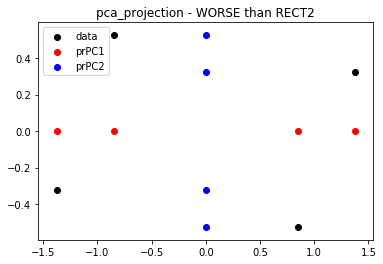



WORSE than RECT2 	  2.8944271909999153

##########################################################################
		Better Rectangle1
##########################################################################

PCA: 
	covariance: 
	 [ 0.33333333 -0.08333333]
	 [-0.08333333  0.5625    ]
	PC: 
	 [-0.30924417  0.95098267]
	 [-0.95098267 -0.30924417]

EVALUATION: 
	transfcoords:
	 [-0.43974208  0.66876894]
	 [0.98673192 0.20490269]
	 [-0.74898626 -0.28221373]
	 [ 0.20199642 -0.5914579 ]
	width:  1.260226843736891 = 0.6687689433547913 - -0.5914579003820998
	height:  1.7357181796599535 = 0.9867319238107423 - -0.7489862558492111
	fingarea:  2.187398643169605



/home/bschroed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: 	WORSE than RECT2
This Area should be smaller!
 BUt it is: 2.8944271909999153 vs. 1.0



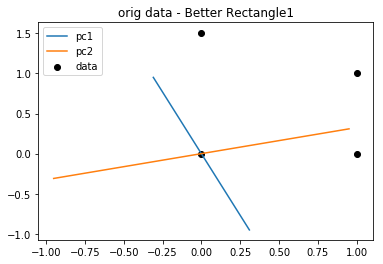

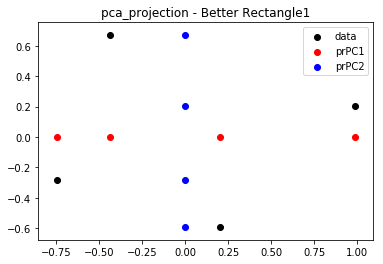



Better Rectangle1 	  2.187398643169605

##########################################################################
		Better Rectangle2
##########################################################################

PCA: 
	covariance: 
	 [1.33333333 0.33333333]
	 [0.33333333 0.91666667]
	PC: 
	 [0.87464248 0.48476853]
	 [ 0.48476853 -0.87464248]

EVALUATION: 
	transfcoords:
	 [-1.23821888  0.17121333]
	 [-0.75345035 -0.70342915]
	 [0.51106608 1.14075039]
	 [ 1.48060315 -0.60853457]
	width:  1.8441795460327084 = 1.1407503933280587 - -0.7034291527046497
	height:  2.718822027279526 = 1.4806031467379994 - -1.2382188805415266
	fingarea:  5.013995972012085



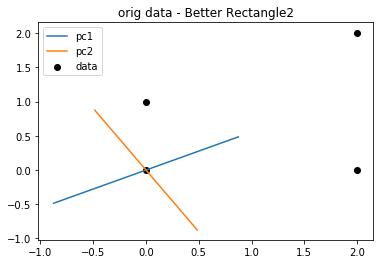

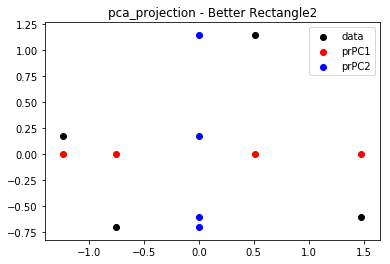



Better Rectangle2 	  5.013995972012085


In [184]:
test_cases_simple(pca_2Darea_sklearn)

In [ ]:
test_case_molecule(pca_2Darea)

In [45]:
#SIMPLE PLOLY AREA
test_cases_simple(PolyArea,  "/home/bschroed/code/restraintmaker/area_log.out")

[(1, 1), (0, 1), (0, 0), (1, 0)]
[(2, 2), (0, 2), (0, 0), (2, 0)]
[(1, 1), (1, 1), (0, 1), (1, 0)]
[(0, 1), (0, 0), (0, 0), (1, 0)]
[(1, 1), (0, 0), (1, 0), (1, 0)]
[(1, 1), (1, 1), (0, 1), (0, 1)]
[(1, 1), (1, 1), (1, 0), (1, 0)]
[(1.0, 1.0), (0.0, 0.5), (0.0, 0.0), (1.0, 0.0)]
[(0.5, 1.0), (0.0, 1.0), (0.0, 0.0), (1.0, 0.0)]
[(1.0, 1.0), (0.0, 1.0), (0.0, 0.0), (0.5, 0.0)]
[(2.0, 1.0), (2.0, 2.0), (0.0, 1.0), (0.0, 0.0)]
[(1.0, 1.0), (0.0, 1.5), (0.0, 0.0), (1.0, 0.0)]
[(2.0, 2.0), (0.0, 1.0), (0.0, 0.0), (2.0, 0.0)]
[(1.0, 1.0), (0.0, 1.0), (0.0, -0.5), (1.0, 0.0)]
[(1, 1), (0, 1), (0, 0), (1, 0)]
[(2, 2), (0, 1), (0, 0), (1, 0)]
[(1, 1), (0, 1), (0, 0), (1, 0)]

Method: PolyArea
title	area	coords
rectangle	1.0	0 0  0 1  1 0  1 1
biggerrectangle	4.0	0 0  0 2  2 0  2 2
Triangle1	0.5	1 1  0 1  1 0  1 1
Triangle2	0.5	0 0  1 0  0 1  0 0
Triangle3	0.5	0 0  1 0  1 0  1 1
Line1	0.0	1 1  0 1  0 1  1 1
Line2	0.0	1 1  1 0  1 0  1 1
WORSE than RECT1	0.75	0 0  0 0.5  1 0  1 1
WORSE than RECT2	0

/home/bschroed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Result is unexpected!
 For this: 0.0 vs. rectangle: 1.0

/home/bschroed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Result is unexpected!
 For this: 2.0 vs. rectangle: 1.0

/home/bschroed/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Result is unexpected!
 For this: 1.0 vs. rectangle: 1.0



In [88]:
test_case_molecule(PolyArea)

[[ 8.463 -3.48  10.746]
 [ 7.884 -0.862  9.516]
 [11.443  0.507  7.003]
 [17.406 -2.811  7.202]]
[(11.443, 0.507), (7.884, -0.862), (8.463, -3.48), (17.406, -2.811)]
first_mol 	  21.88611699999999


In [61]:
def pca_2D_polygonArea(coords:np.array, title:str):

    #CALC_PCA
    dims = 2
    #Calculate _pca
    transformed_coords, pc_components, eigen_values, covaricance_matrix = _calc_pca(coords, dims)
    
    spacer = "\n##########################################################################\n"
    print(spacer+"\t\t"+title+spacer)
    print("PCA: ")
    print("\tcovariance: \n\t","\n\t ".join(map(str, list(covaricance_matrix))))
    print("\tPC: \n\t", "\n\t ".join(map(str, list(pc_components))))
    print("\teigenvalues: ",eigen_values)
    
    
    area = PolyArea(transformed_coords.T)
    
    print("\nEVALUATION: ")
    print("\ttransfcoords:\n\t", "\n\t ".join(map(str, list(transformed_coords.T))))
    print("\tfingarea: ", area)
    print()
    
    #PLOT
    if(len(coords[0]) == 3):
        _plot_3D_PCA(coords, pc_components, title)
    #plot orig data
    _plot_data(coords, pc_components, title)
    ##porjection of data
    _plot_pc_projection(transformed_coords, title)
    
    print()
    print()
    return area   


##########################################################################
		rectangle
##########################################################################

PCA: 
	covariance: 
	 [0.33333333 0.        ]
	 [0.         0.33333333]
	PC: 
	 [1. 0.]
	 [0. 1.]
	eigenvalues:  [0.33333333 0.33333333]
[(0.5, 0.5), (-0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)]

EVALUATION: 
	transfcoords:
	 [-0.5 -0.5]
	 [-0.5  0.5]
	 [ 0.5 -0.5]
	 [0.5 0.5]
	fingarea:  1.0



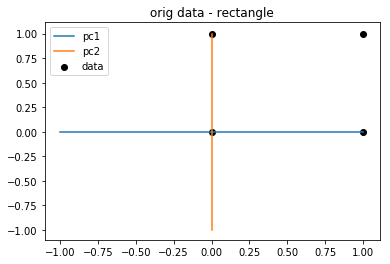

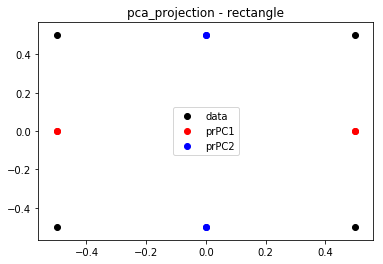




##########################################################################
		biggerrectangle
##########################################################################

PCA: 
	covariance: 
	 [1.33333333 0.        ]
	 [0.         1.33333333]
	PC: 
	 [1. 0.]
	 [0. 1.]
	eigenvalues:  [1.33333333 1.33333333]
[(1.0, 1.0), (-1.0, 1.0), (-1.0, -1.0), (1.0, -1.0)]

EVALUATION: 
	transfcoords:
	 [-1. -1.]
	 [-1.  1.]
	 [ 1. -1.]
	 [1. 1.]
	fingarea:  4.0



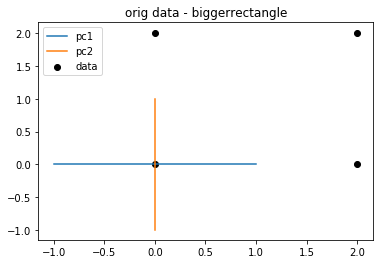

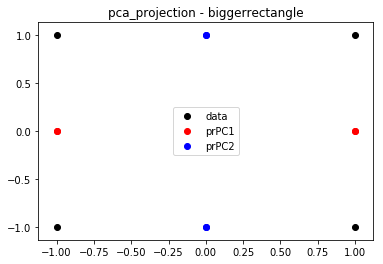




##########################################################################
		Triangle1
##########################################################################

PCA: 
	covariance: 
	 [ 0.25       -0.08333333]
	 [-0.08333333  0.25      ]
	PC: 
	 [0.70710678 0.70710678]
	 [-0.70710678  0.70710678]
	eigenvalues:  [0.33333333 0.16666667]
[(0.0, 0.35355339059327373), (0.0, 0.35355339059327373), (-0.7071067811865475, -0.35355339059327373), (0.7071067811865475, -0.35355339059327373)]

EVALUATION: 
	transfcoords:
	 [0.         0.35355339]
	 [-0.70710678 -0.35355339]
	 [ 0.70710678 -0.35355339]
	 [0.         0.35355339]
	fingarea:  0.4999999999999999



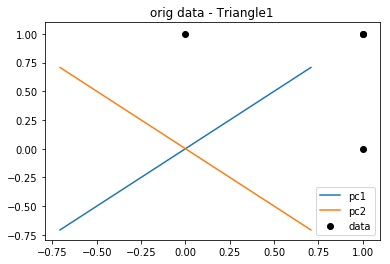

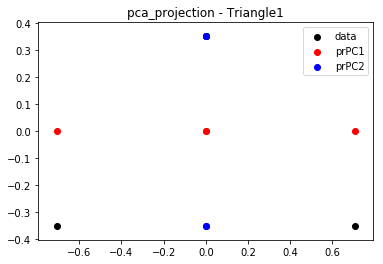




##########################################################################
		Triangle2
##########################################################################

PCA: 
	covariance: 
	 [ 0.25       -0.08333333]
	 [-0.08333333  0.25      ]
	PC: 
	 [0.70710678 0.70710678]
	 [-0.70710678  0.70710678]
	eigenvalues:  [0.33333333 0.16666667]
[(0.7071067811865475, 0.35355339059327373), (-0.7071067811865475, 0.35355339059327373), (0.0, -0.35355339059327373), (0.0, -0.35355339059327373)]

EVALUATION: 
	transfcoords:
	 [ 0.         -0.35355339]
	 [0.70710678 0.35355339]
	 [-0.70710678  0.35355339]
	 [ 0.         -0.35355339]
	fingarea:  0.4999999999999999



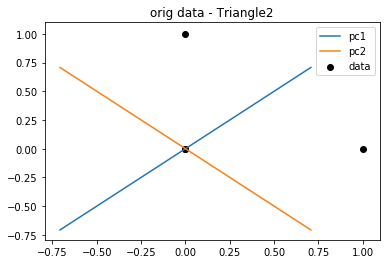

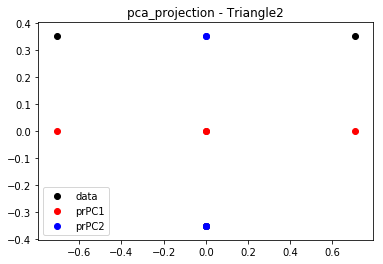




##########################################################################
		Triangle3
##########################################################################

PCA: 
	covariance: 
	 [0.25       0.08333333]
	 [0.08333333 0.25      ]
	PC: 
	 [ 0.70710678 -0.70710678]
	 [0.70710678 0.70710678]
	eigenvalues:  [0.33333333 0.16666667]
[(0.7071067811865475, 0.35355339059327373), (-0.7071067811865475, 0.35355339059327373), (0.0, -0.35355339059327373), (0.0, -0.35355339059327373)]

EVALUATION: 
	transfcoords:
	 [-0.70710678  0.35355339]
	 [ 0.         -0.35355339]
	 [ 0.         -0.35355339]
	 [0.70710678 0.35355339]
	fingarea:  0.4999999999999999



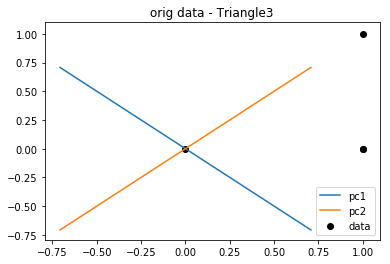

In [65]:

test_cases_simple(pca_2D_polygonArea, "/home/bschroed/code/restraintmaker/area_log.out")

In [11]:
test_case_molecule(pca_2D_polygonArea)

NameError: name 'test_case_molecule' is not defined

In [12]:
#calculating polygon with rdkit func  
def rdkit2D_polygonArea(mol:Chem.Mol, selected_atom_idxs, title:str):
    AllChem.Compute2DCoords(mol)    #uses PCA

    conf = mol.GetConformers()[0]
    pos = conf.GetPositions()

    #get selected-coords 
    selected_arr = np.array([list(pos[sele]) for sele in selected_atom_idxs])[:,:2]
    print(selected_arr[:,:2])

    spacer = "\n##########################################################################\n"
    print(spacer+"\t\t"+title+spacer)
    
    area = PolyArea(selected_arr)
    
    print("\nEVALUATION: ")
    print("\ttransfcoords:\n\t", "\n\t ".join(map(str, list(selected_arr.T))))
    print("\tfingarea: ", area)
    print()
    
    #PLOT
    _plot_2D_PCA(pos, selected_arr, [[0,0], [0,0]], mol_name=mol.name)
    print()
    print()
    return area   


NameError: name 'Chem' is not defined

In [10]:
test_case_molecule_rdkit(rdkit2D_polygonArea)


NameError: name 'test_case_molecule_rdkit' is not defined